In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [75]:
df = pd.read_csv('washing_machine.csv')

In [76]:
df_copy = df.copy()
df_copy.drop(['model_code'], axis=1, inplace=True)
categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
df_copy.shape

(272, 12)

one hot encoding

In [77]:
df_copy = pd.get_dummies(df_copy, columns=categorical_cols)

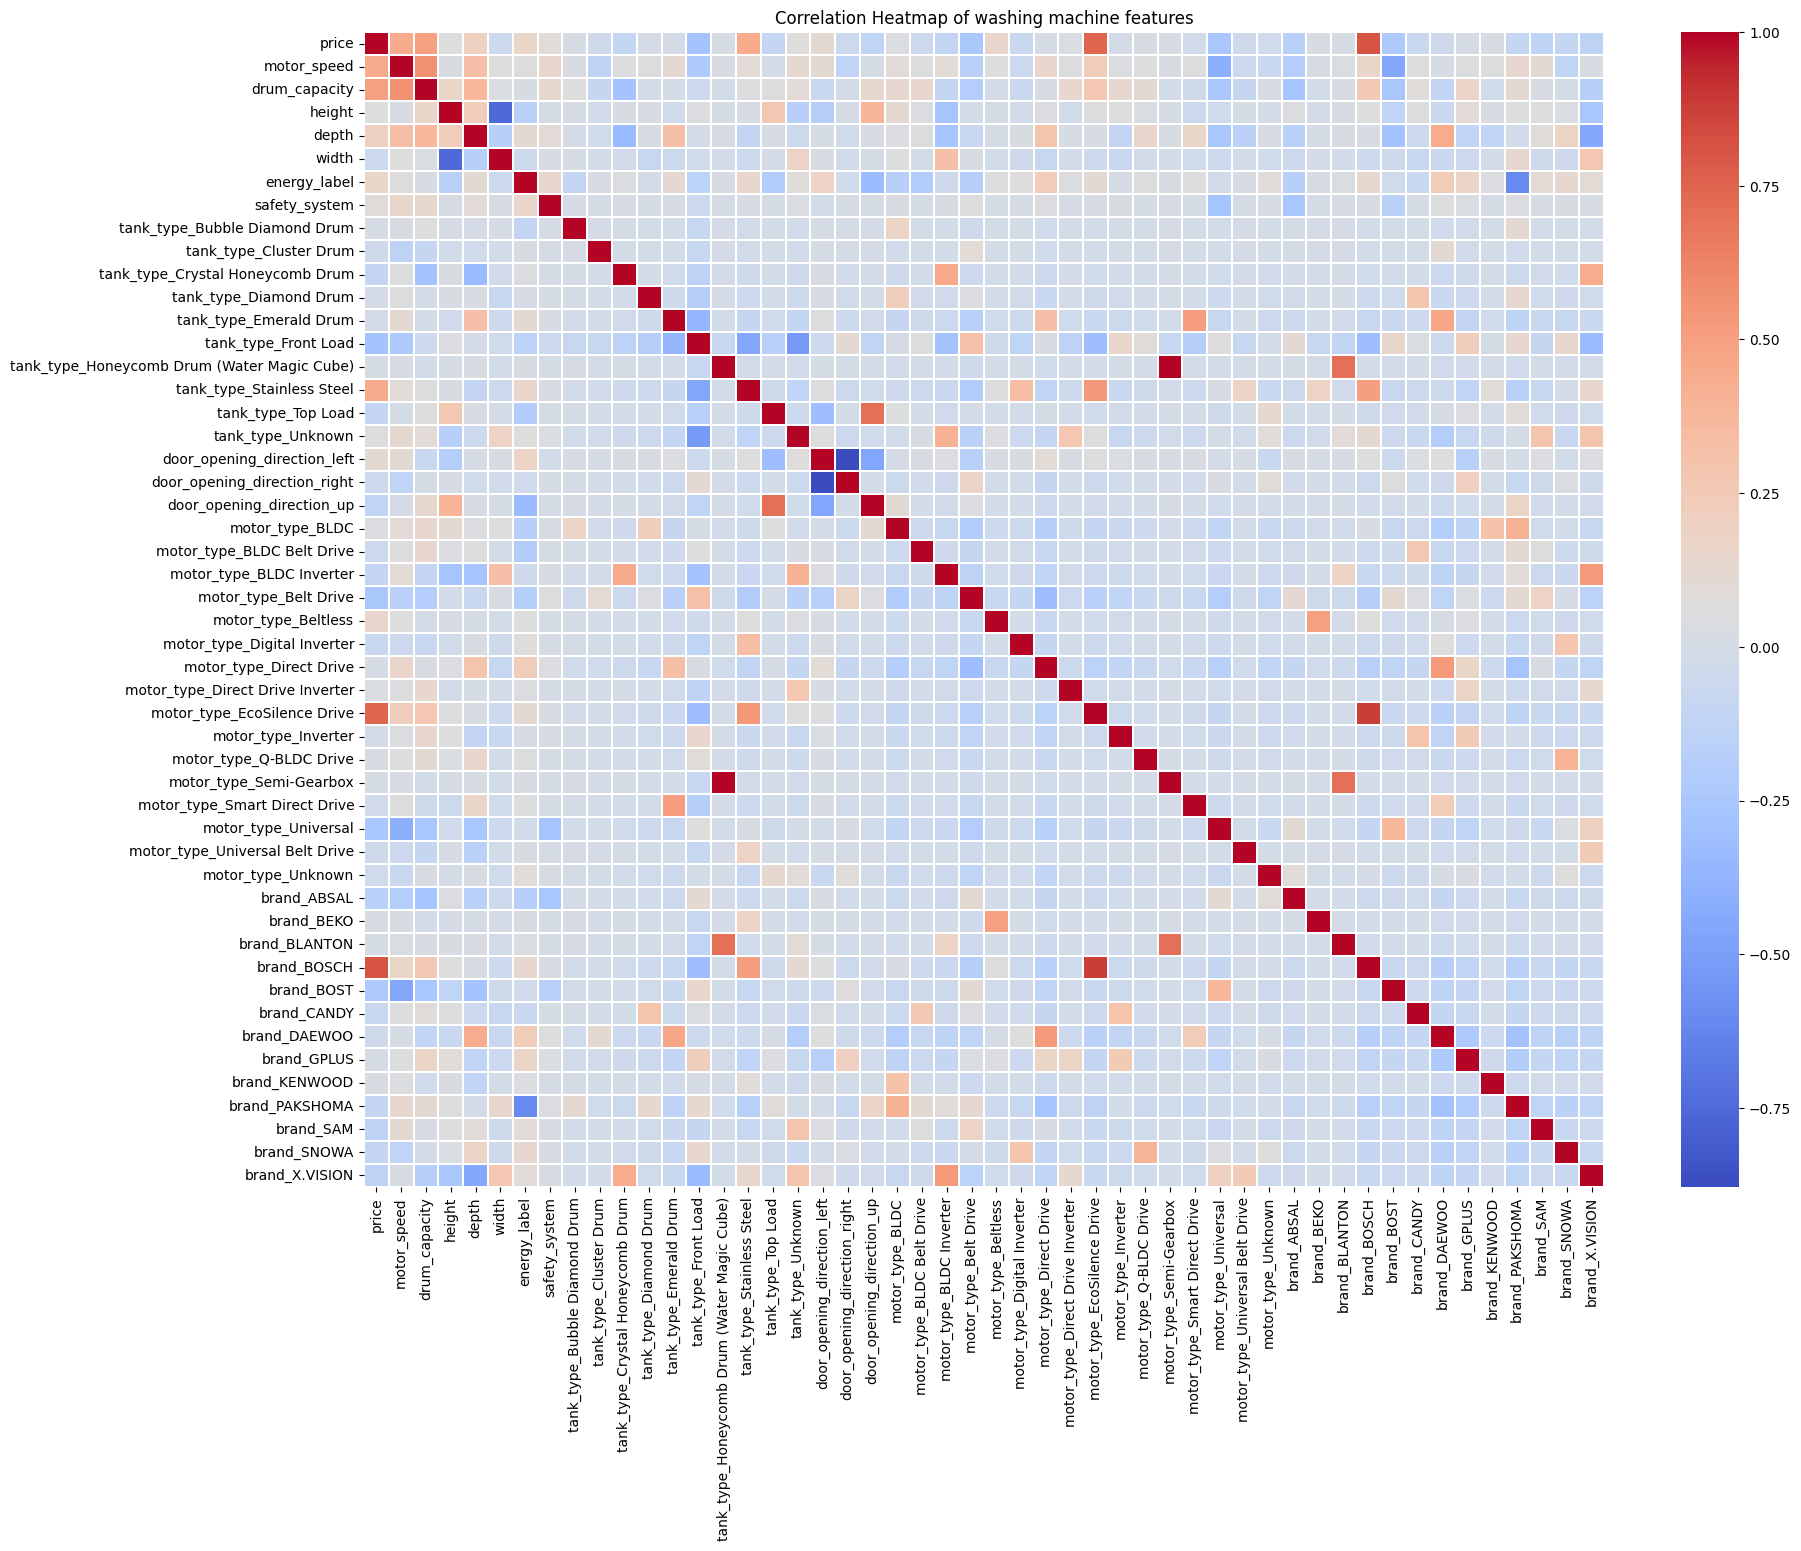

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Plot the heatmap

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix,annot=False, cmap='coolwarm', linewidths=0.2)

# Title
plt.title("Correlation Heatmap of washing machine features")

# Show plot
plt.show()


remove high corrolated feature

In [79]:
threshold = 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns 
          if any((upper_tri[column] > threshold) | (upper_tri[column] < -threshold))]

# Drop the highly correlated columns
wm_cleaned = df_copy.drop(columns=[col for col in to_drop if col in df_copy.columns])

print(f"Dropped columns: {to_drop}")
# print(f"Original shape: {wm.shape}")
print(f"New shape: {wm_cleaned.shape}")

Dropped columns: ['door_opening_direction_right', 'motor_type_Semi-Gearbox', 'brand_BOSCH']
New shape: (272, 47)


 Feature Selection Based on Variance

In [80]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
selected_features = selector.fit_transform(wm_cleaned)


In [81]:
wm_cleaned = selected_features

In [82]:
df_copy.columns

Index(['price', 'motor_speed', 'drum_capacity', 'height', 'depth', 'width',
       'energy_label', 'safety_system', 'tank_type_Bubble Diamond Drum',
       'tank_type_Cluster Drum', 'tank_type_Crystal Honeycomb Drum',
       'tank_type_Diamond Drum', 'tank_type_Emerald Drum',
       'tank_type_Front Load', 'tank_type_Honeycomb Drum (Water Magic Cube)',
       'tank_type_Stainless Steel', 'tank_type_Top Load', 'tank_type_Unknown',
       'door_opening_direction_left', 'door_opening_direction_right',
       'door_opening_direction_up', 'motor_type_BLDC',
       'motor_type_BLDC Belt Drive', 'motor_type_BLDC Inverter',
       'motor_type_Belt Drive', 'motor_type_Beltless',
       'motor_type_Digital Inverter', 'motor_type_Direct Drive',
       'motor_type_Direct Drive Inverter', 'motor_type_EcoSilence Drive',
       'motor_type_Inverter', 'motor_type_Q-BLDC Drive',
       'motor_type_Semi-Gearbox', 'motor_type_Smart Direct Drive',
       'motor_type_Universal', 'motor_type_Universal Belt 

In [83]:
wm_cleaned.shape

(272, 14)

clustering

In [84]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Assuming df is your dataframe
scaler =StandardScaler()
df_scaled = scaler.fit_transform(wm_cleaned)


kmeans

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_kmeans(data, k_range):
    best_k = None
    best_score = -1
    best_metrics = {}

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, labels)
        calinski_harabasz_avg = calinski_harabasz_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
        
        # Combine the scores into a single metric for comparison
        combined_score = silhouette_avg + calinski_harabasz_avg - davies_bouldin_avg
        
        if combined_score > best_score:
            best_score = combined_score
            best_k = k
            best_metrics = {
                'silhouette_score': silhouette_avg,
                'calinski_harabasz_score': calinski_harabasz_avg,
                'davies_bouldin_score': davies_bouldin_avg
            }
            best_k_labels = labels
    
    return best_k, best_metrics,best_k_labels

# Define the range of k values to search
k_range = range(2, 11)


# Evaluate KMeans clustering
best_k, best_metrics,kmean_labels = evaluate_kmeans(df_scaled, k_range)

print(f"Best k: {best_k}")
print(f"Best metrics: {best_metrics}")

Best k: 7
Best metrics: {'silhouette_score': np.float64(0.3113139738792331), 'calinski_harabasz_score': np.float64(58.999439477138296), 'davies_bouldin_score': np.float64(1.2053197813528433)}


In [86]:
kmean_labels

array([2, 2, 2, 2, 2, 2, 2, 0, 0, 4, 4, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       4, 4, 6, 6, 6, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 4, 4,
       4, 0, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 4, 2, 2, 0, 2, 2, 3, 3, 3,
       0, 0, 0, 2, 2, 0, 2, 3, 4, 0, 0, 2, 0, 0, 3, 2, 2, 2, 2, 1, 1, 1,
       4, 4, 2, 2, 2, 4, 4, 4], dtype=int32)

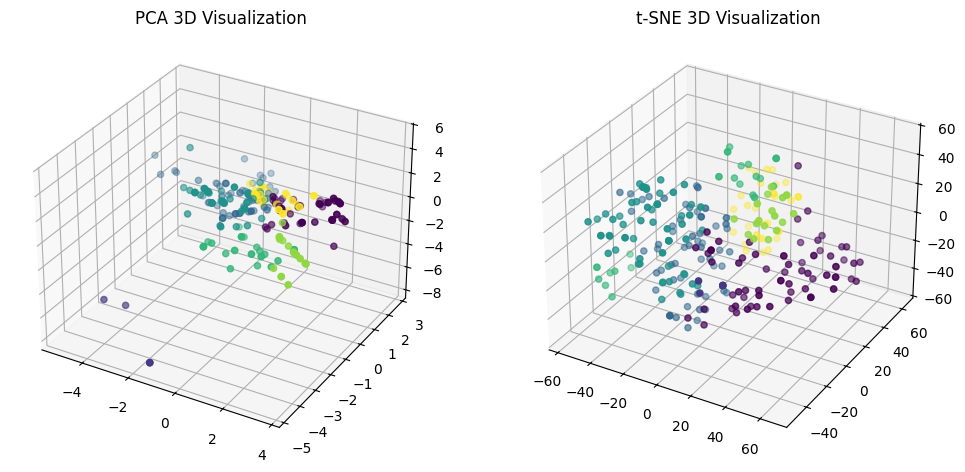

In [87]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Perform t-SNE to reduce dimensions to 3
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

# Plot PCA result
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=kmean_labels, marker='o')
ax.set_title('PCA 3D Visualization')

# Plot t-SNE result
ax = fig.add_subplot(122, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=kmean_labels, marker='o')
ax.set_title('t-SNE 3D Visualization')

plt.show()

DBSCAN

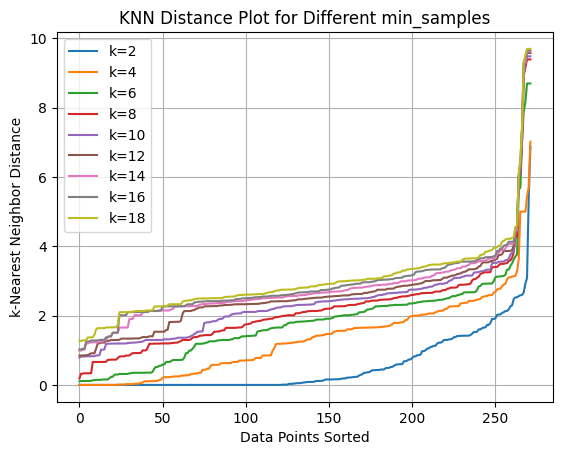

In [88]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

for k in range(2,20,2):  # Test different min_samples values
    nbrs = NearestNeighbors(n_neighbors=k).fit(df_scaled)
    distances, indices = nbrs.kneighbors(df_scaled)
    
    sorted_distances = np.sort(distances[:, k-1])  # k-th nearest neighbor
    plt.plot(sorted_distances, label=f'k={k}')

plt.xlabel("Data Points Sorted")
plt.ylabel("k-Nearest Neighbor Distance")
plt.title("KNN Distance Plot for Different min_samples")
plt.legend()
plt.grid()
plt.show()


In [97]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=3.5, min_samples=8)
dbscan_labels = dbscan.fit_predict(df_scaled)

# Calculate the scores
silhouette_avg = silhouette_score(df_scaled, dbscan_labels)
calinski_harabasz_avg = calinski_harabasz_score(df_scaled, dbscan_labels)
davies_bouldin_avg = davies_bouldin_score(df_scaled, dbscan_labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin_avg}")

Silhouette Score: 0.46155252627386695
Calinski-Harabasz Score: 19.06209451568994
Davies-Bouldin Score: 1.9793648307337006


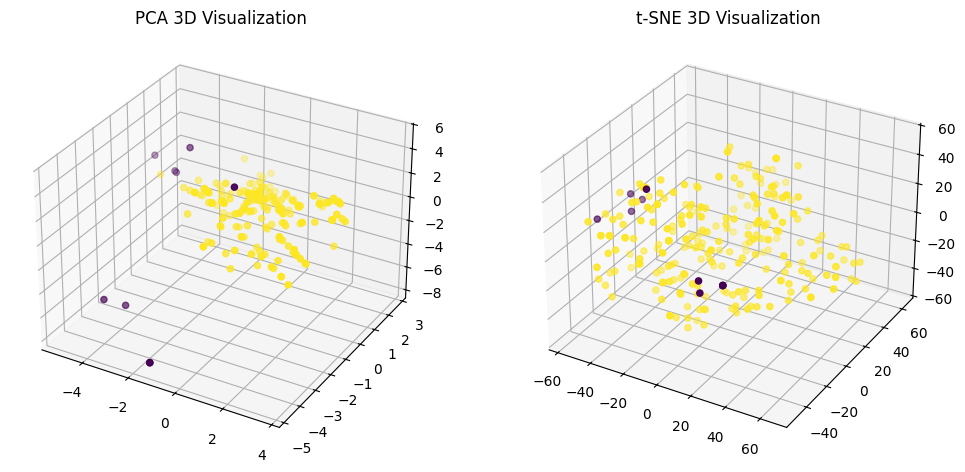

In [98]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Perform t-SNE to reduce dimensions to 3
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

# Plot PCA result
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=dbscan_labels, marker='o')
ax.set_title('PCA 3D Visualization')

# Plot t-SNE result
ax = fig.add_subplot(122, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=dbscan_labels, marker='o')
ax.set_title('t-SNE 3D Visualization')

plt.show()

In [95]:
wm_cleaned

array([[1.64515e+07, 1.20000e+03, 7.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.64515e+07, 1.20000e+03, 7.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.56100e+07, 1.20000e+03, 7.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.96000e+07, 1.40000e+03, 8.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.96000e+07, 1.40000e+03, 8.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.35000e+07, 1.40000e+03, 1.00000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]], shape=(272, 14))

In [102]:
print(pca.explained_variance_ratio_)  # Importance of each component
pca_comp = pca.components_  # Contribution of each feature

# Get top 5 absolute values for each component
top_5_indices = np.argsort(-np.abs(pca_comp), axis=1)[:, :5]  # Sort and take top 5

print(top_5_indices)

[0.19414452 0.15494002 0.14432632]
[[ 0  1  4  2  9]
 [11  8 13 10  5]
 [ 3  5  6 13  2]]


In [108]:
important_cols_pca1 = df_copy.columns[top_5_indices[0]]
important_cols_pca1

Index(['price', 'motor_speed', 'depth', 'drum_capacity',
       'tank_type_Cluster Drum'],
      dtype='object')

In [109]:
important_cols_pca2 = df_copy.columns[top_5_indices[1]]
important_cols_pca2

Index(['tank_type_Diamond Drum', 'tank_type_Bubble Diamond Drum',
       'tank_type_Front Load', 'tank_type_Crystal Honeycomb Drum', 'width'],
      dtype='object')

In [110]:
important_cols_pca3 = df_copy.columns[top_5_indices[2]]
important_cols_pca3

Index(['height', 'width', 'energy_label', 'tank_type_Front Load',
       'drum_capacity'],
      dtype='object')